In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
# Dummy data to test
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-02'),
    first_days=5,
    split='train',
    tp_log=1e-1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
# Using first few days of every month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    mins=ds_train.mins,
    maxs=ds_train.maxs,
    first_days=2,
    tp_log=1e-1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(
    ds_train.compute_weights(), len(ds_train)
)

In [8]:
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=32, sampler=sampler_train
)

In [9]:
gen = Generator(
    nres=1, nf_in=1, nf=16, use_noise=True, activation_out='relu'
).to(device)

In [10]:
X, y = next(iter(dl_train))

In [11]:
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 1, 128, 128]))

In [31]:
preds = np.array([gen(X.to(device).float()).detach().to('cpu').numpy() 
                        for _ in range(10)]).squeeze()

In [32]:
preds.shape

(10, 32, 128, 128)

In [33]:
preds = xr.DataArray(
        preds,
        dims=['member', 'sample', 'lat', 'lon'],
        name='tp'
    )

In [38]:
preds = preds * (ds_train.maxs.tp.values - ds_train.mins.tp.values) + ds_train.mins.tp.values

In [47]:
preds = log_retrans(preds, ds_train.tp_log)

In [48]:
preds

<xarray.DataArray 'tp' (member: 10, sample: 32, lat: 128, lon: 128)>
array([[[[ 3.19499671e-01,  7.37923741e-01,  8.48828733e-01, ...,
           1.42076063e+00,  1.64632809e+00,  4.53027201e+00],
         [ 4.42428857e-01,  3.30320120e-01,  3.17788929e-01, ...,
           4.91015404e-01,  5.83112180e-01,  8.49855185e-01],
         [ 6.02299750e-01,  5.45424521e-01,  5.36112726e-01, ...,
           7.66475558e-01,  7.53498435e-01,  8.92190933e-01],
         ...,
         [ 6.22002304e-01,  6.89949095e-01,  6.55933142e-01, ...,
           7.66003907e-01,  8.30895901e-01,  1.09382188e+00],
         [ 5.92176378e-01,  7.69864857e-01,  7.24602163e-01, ...,
           7.77748048e-01,  8.28463197e-01,  9.92039561e-01],
         [ 4.95011657e-01,  1.35835528e-01,  1.15603991e-01, ...,
           7.32751712e-02,  5.52762672e-02, -7.45058060e-09]],

        [[ 3.01582515e-01,  6.41577363e-01,  7.59911180e-01, ...,
           1.85871482e+00,  2.10259748e+00,  5.80122709e+00],
         [ 4.10623163e-01,  2.86466449e-01,  2.79020250e-01, ...,
           6.41290784e-01,  7.46967375e-01,  1.13736856e+00],
         [ 5.80363214e-01,  4.98761028e-01,  5.00952363e-01, ...,
           9.04610872e-01,  8.76834571e-01,  1.12544763e+00],
...
           7.70256102e-01,  8.25182080e-01,  1.07088614e+00],
         [ 6.13334715e-01,  8.78633678e-01,  8.41654062e-01, ...,
           8.04779708e-01,  8.40527058e-01,  9.70570803e-01],
         [ 5.24026990e-01,  1.48046196e-01,  1.28497928e-01, ...,
           8.23593512e-02,  4.99825999e-02, -7.45058060e-09]],

        [[ 3.32794726e-01,  7.89800823e-01,  9.13342357e-01, ...,
           1.92071664e+00,  2.12609124e+00,  5.77878618e+00],
         [ 4.58523363e-01,  3.55414718e-01,  3.45615208e-01, ...,
           6.49165690e-01,  7.36665905e-01,  1.06302023e+00],
         [ 6.11244500e-01,  5.53657472e-01,  5.50095618e-01, ...,
           9.43200827e-01,  8.79152715e-01,  1.04904151e+00],
         ...,
         [ 6.14366233e-01,  6.61792994e-01,  6.60209835e-01, ...,
           7.53956020e-01,  7.81481564e-01,  9.65118885e-01],
         [ 5.89169502e-01,  7.07327366e-01,  6.87557876e-01, ...,
           7.70585597e-01,  7.93282807e-01,  8.76256406e-01],
         [ 4.80320007e-01,  1.09784417e-01,  9.85139385e-02, ...,
           7.42009506e-02,  4.15008292e-02, -7.45058060e-09]]]],
      dtype=float32)
Dimensions without coordinates: member, sample, lat, lon

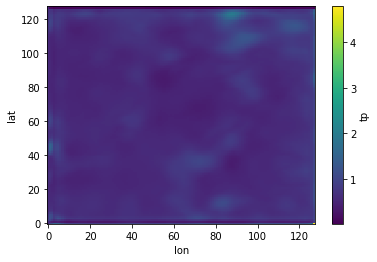

In [49]:
preds.isel(member=4, sample=0).plot()

In [35]:
truth = xr.DataArray(
        y.numpy().squeeze(),
        dims=['sample', 'lat', 'lon'],
        name='tp'
    )

In [44]:
truth = truth * (ds_train.maxs.tp.values - ds_train.mins.tp.values) + ds_train.mins.tp.values

In [51]:
truth = log_retrans(truth, ds_train.tp_log)

In [52]:
truth

<xarray.DataArray 'tp' (sample: 32, lat: 128, lon: 128)>
array([[[1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         5.16544326e+00, 5.35086415e+00, 5.52388295e+00],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         5.12583506e+00, 4.94158821e+00, 4.45950164e+00],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         5.48388518e+00, 5.07309331e+00, 5.16544326e+00],
        ...,
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.48312700e-02, 1.38777878e-17],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 3.76147545e-02, 1.38777878e-17],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17]],

       [[9.70910135e+00, 8.77430018e+00, 8.96014255e+00, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [1.29376186e+01, 1.20655934e+01, 1.19758954e+01, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [1.78486142e+01, 1.74847329e+01, 1.69488540e+01, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
...
        [5.71463186e-01, 7.49862376e-01, 9.23660788e-01, ...,
         4.16354666e+00, 3.53078817e+00, 2.70836341e+00],
        [9.34029827e-01, 9.44414575e-01, 1.04908672e+00, ...,
         3.25732594e+00, 2.78070554e+00, 1.97795940e+00],
        [1.12321667e+00, 1.11258468e+00, 1.32773899e+00, ...,
         2.88972584e+00, 2.18660986e+00, 1.29513807e+00]],

       [[2.85331926e+00, 2.75656163e+00, 2.91403410e+00, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [2.91403410e+00, 2.80488112e+00, 2.64828732e+00, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [2.61233529e+00, 2.22166885e+00, 1.61474195e+00, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        ...,
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17],
        [1.38777878e-17, 1.38777878e-17, 1.38777878e-17, ...,
         1.38777878e-17, 1.38777878e-17, 1.38777878e-17]]])
Dimensions without coordinates: sample, lat, lon

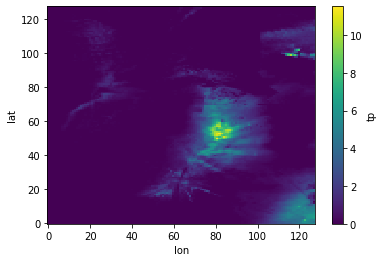

In [53]:
truth.isel(sample=0).plot()

In [54]:
from src.evaluation import *

In [55]:
xs.crps_ensemble(truth, preds)

<xarray.DataArray 'tp' ()>
array(1.78865609)